# Cell Level X2A

In [3]:
# %load start.py
# Imports
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.x_to_a import (
    CHROMS_CHR, MAJOR_ARMS_CHR, commonly_expressed, idx_stats_by_cluster, multi_chrom_boxplot, 
    x_autosome_boxplot, estimate_dcc 
)
from larval_gonad.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook('2018-03-01_cell_level_x2a', fig_dir='../output/figures', subproject_dir='../output/cell_level_x2a', seurat_dir='../output/testis1_scRNAseq')

last updated: 2018-03-01 
Git hash: 70a3f6da6f73b7b05e166d33f3e071a440e5f891


In [4]:
# Import data from testes
norm = nbconfig.seurat.get_normalized_read_counts()
clusters = nbconfig.seurat.get_clusters()

# Re-order columns
norm = norm[clusters.index].copy()
data = norm.T.join(clusters)

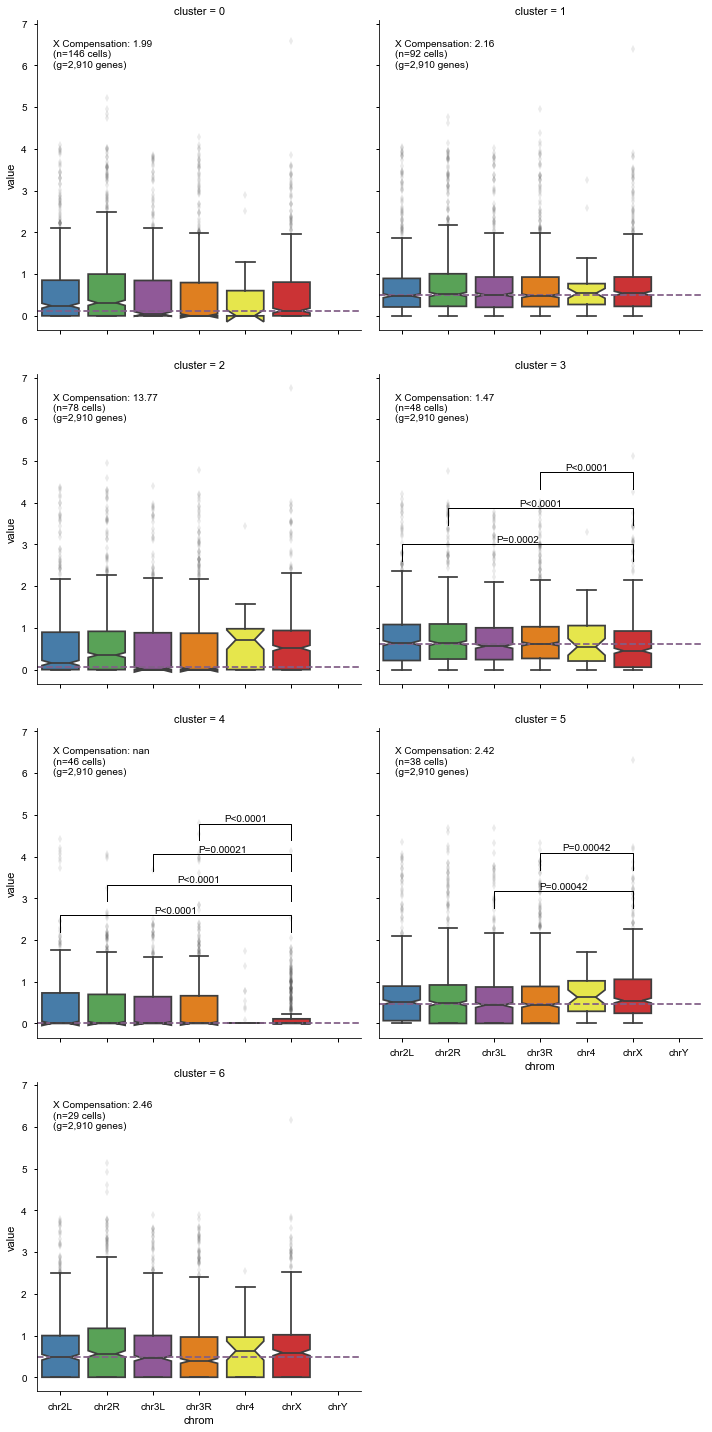

In [5]:
expressed = commonly_expressed(norm)
dat = data.groupby('cluster').median().T.loc[expressed, :].reset_index()\
    .melt(id_vars='index')\
    .merge(nbconfig.fbgn2chrom, left_on='index', right_index=True)\
    .set_index('index')

def _plot(dat):
    mpl.rcParams['pdf.fonttype'] = 42
    num_cells = data.groupby('cluster').count().iloc[:, 0].to_dict()
    g = sns.FacetGrid(dat, col='cluster', col_wrap=2, size=5)
    g.map_dataframe(multi_chrom_boxplot, 'chrom', 'value', num_cells=num_cells, palette=nbconfig.color_chrom, 
                    notch=True, flierprops=nbconfig.fliersprops)

_plot(dat)

In [6]:
dat = norm[norm.index.isin(expressed)].join(nbconfig.fbgn2chrom, how='left').set_index('chrom', append=True)

In [36]:
res = []
for i, _dd in norm.T.iterrows():
    _chrom = pd.concat([_dd[expressed], nbconfig.fbgn2chrom], axis=1, join='inner')
    _on = _chrom[i] > 0
    _chrom = _chrom[_on]
    x = _chrom[_chrom['chrom'] == 'chrX'][i]
    a = _chrom[_chrom.chrom.isin(MAJOR_ARMS_CHR)][i]
    try:
        prop = x.median() / a.median()
    except ZeroDivisionError:
        prop = np.nan
        
    res.append([i, (~_on).sum(), x.sum(), x.shape[0], a.sum(), a.shape[0], prop])

In [37]:
res = pd.DataFrame(res, columns=['cellID', 'genes_off', 'xMed', 'xSize', 'aMed', 'aSize', 'prop']).set_index('cellID').join(clusters)

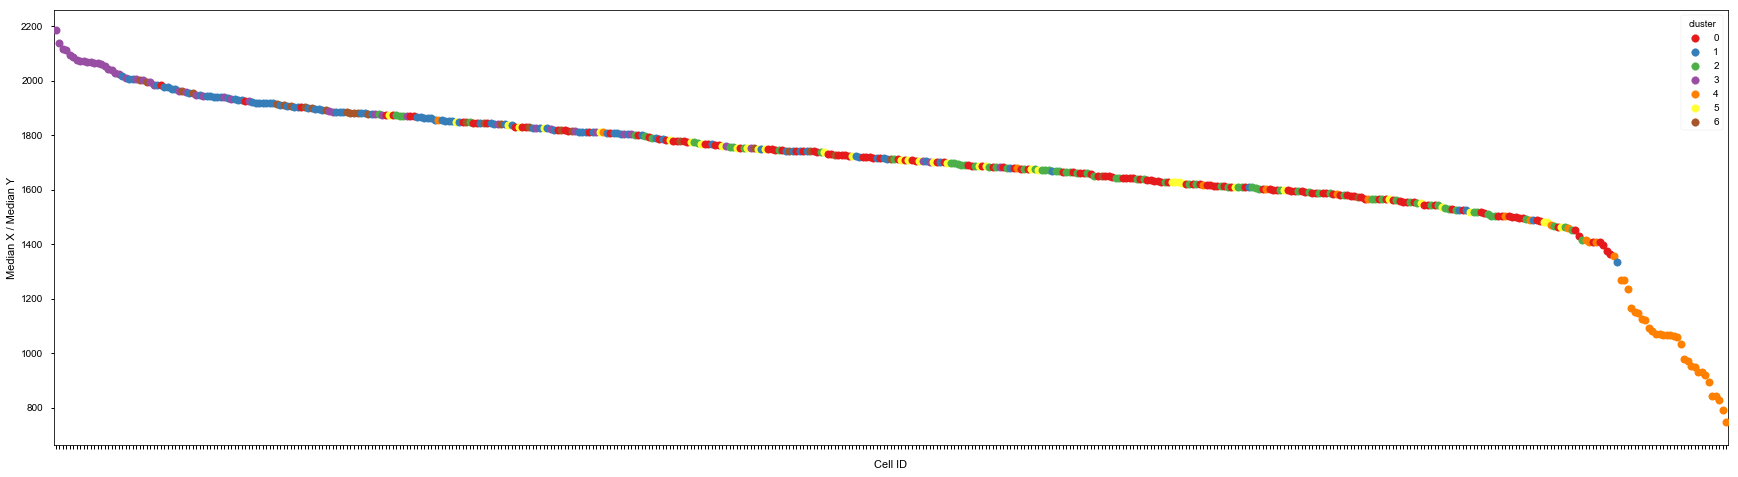

In [40]:
#@make_figs(nbconfig.fig_name('stripplot_x2a'), styles=nbconfig.styles, formats=nbconfig.formats)
def _plot():
    fig, ax = plt.subplots(1, 1, figsize=(30, 8))
    order = res.aMed.sort_values().index.tolist()
    sns.stripplot(x='cellID', y='aMed', data=res.reset_index(), hue='cluster', order=reversed(order), ax=ax, s=8)
    ax.set_xticklabels([])
    ax.set_ylabel('Median X / Median Y')
    ax.set_xlabel('Cell ID')

_plot()

In [43]:
def _plot(dat, cluster, ax):
    _sub = dat[dat.cluster == cluster]
    order = _sub.sort_values('xMed').index.tolist()
    
    sns.stripplot(x='cellID', y='xMed', data=_sub.reset_index(), order=reversed(order), color='k', alpha=.6, ax=ax)
    ax.set_xticklabels([])
    ax.set_title(cluster)
    ax.set_ylabel('')
    ax.set_xlabel('Cell ID')

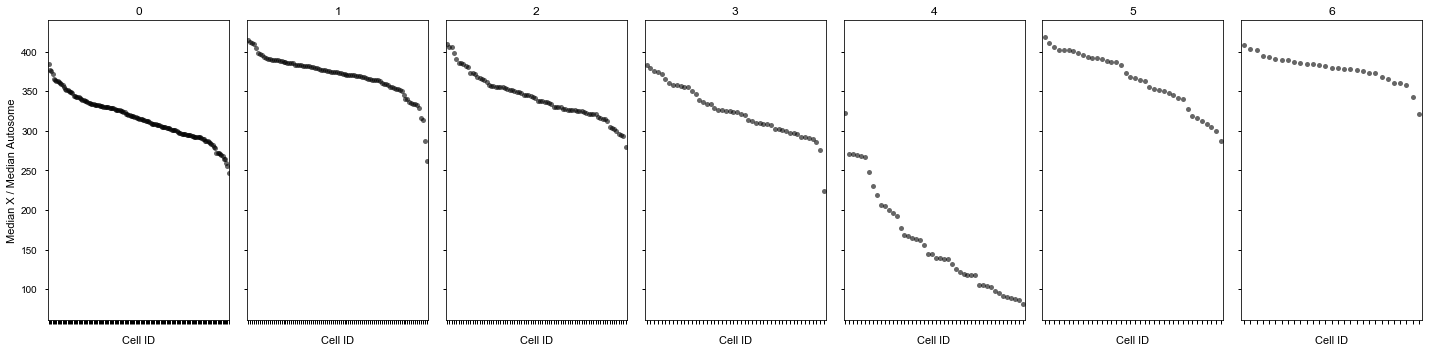

In [44]:
#@make_figs(nbconfig.fig_name('stripplot_x2a_by_cluster'), styles=nbconfig.styles, formats=nbconfig.formats)
def _plot2():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharey=True)

    for i, ax in enumerate(axes):
        _plot(res, i, ax)

    axes[0].set_ylabel('Median X / Median Autosome')
    plt.tight_layout();

_plot2()

In [19]:
res.groupby('cluster').genes_off.median()

cluster
0    1437.0
1     716.0
2    1472.5
3     770.5
4    1763.5
5     938.5
6    1330.0
Name: genes_off, dtype: float64

In [45]:
res

,genes_off,xMed,xSize,aMed,aSize,prop,cluster
cellID,,,,,,,
AAACCTGGTTCATGGT,2203,91.944105,77,893.690713,627,1.000000,4
AAACGGGAGACTGGGT,857,402.643353,344,1955.466144,1675,1.000000,6
AAACGGGGTGTTAAGA,665,385.321192,369,1857.315278,1846,1.000000,1
AAAGATGAGTATCGAA,1271,401.678934,271,1960.834361,1340,1.000000,6
AAAGCAAGTCTAGGTT,226,382.806412,435,2113.400611,2206,0.908865,3
AAATGCCGTAAAGGAG,1147,334.822619,302,1629.713266,1430,1.000000,2
AACCATGCAGTACACT,1181,371.070940,301,1737.330944,1393,1.000000,2
AACCGCGCAGCGTCCA,1052,379.310460,306,1862.782256,1523,1.000000,1
AACGTTGAGTACCGGA,1408,316.283471,237,1676.996242,1243,1.000000,2
